# ***Upload de dados tif para o GEE.***

Vamos utlizar as assets do GEE para armazenar as informações e realizar análises.

* upload via asset
* criar pilha de dados
* Extrair valores por pixel
* Export CSV


In [ ]:
##Instalando bibliotecas
!pip install earthengine-api geemap geopandas geobr rtree pyproj rasterio contextily descartes -q

In [ ]:
##Importando pacotes
import rasterio as rio
from rasterio.transform import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import ee
import json
import seaborn as sns

# **Extrair os pontos a partir do ReduceRegion**

In [ ]:
##Autenticão GEE
ee.Authenticate()
ee.Initialize()

In [ ]:
##Criando as variáveis a partir da pilha de imagens
iso_oxi_stack = ee.Image('users/treinamento_GEE_00/TNC/Iso_Oxi_Stack').select(['b.*'],['Oxi_1','Oxi_2','Oxi_3','Oxi_4','Oxi_5','Oxi_6','Oxi_7','Oxi_8','Oxi_9','Oxi_10','Oxi_11','Oxi_12'])
iso_oxi_stack_Terzer = ee.Image('users/treinamento_GEE_00/TNC/Iso_Oxi_Stack_mean_TERZER').select(['b.*'],['Oxi_Terzer_mean'])
brisoscape_stack_ISORIX = ee.Image('users/treinamento_GEE_00/TNC/brisoscape_mean_ISORIX').select(['b.*'],['Briso_Isorix_mean'])
predokrig_Isorg = ee.Image('users/treinamento_GEE_00/TNC/predkrig_br_lat_ISORG').select(['b.*'],['predokrig_Isorg'])
r_rh_stack = ee.Image('users/treinamento_GEE_00/TNC/R_rh_Stack').select(['b.*'],['rh_1','rh_2','rh_3','rh_4','rh_5','rh_6','rh_7','rh_8','rh_9','rh_10','rh_11','rh_12'])
r_vpd_stack = ee.Image('users/treinamento_GEE_00/TNC/R_vpd_Stack').select(['b.*'],['vpd_1','vpd_2','vpd_3','vpd_4','vpd_5','vpd_6','vpd_7','vpd_8','vpd_9','vpd_10','vpd_11','vpd_12'])
temperatura_stack= ee.Image('users/treinamento_GEE_00/TNC/Temperatura_Stack').select(['b.*'], ['temp_1','temp_2','temp_3','temp_4','temp_5','temp_6','temp_7','temp_8','temp_9','temp_10','temp_11','temp_12'])
iso_O_Cel = ee.Image('users/treinamento_GEE_00/TNC/iso_O_cel').select(['b.*'],['O_cel_1','O_cel_2','O_cel_3','O_cel_4','O_cel_5','O_cel_6','O_cel_7','O_cel_8','O_cel_9','O_cel_10','O_cel_11','O_cel_12'])
ponto_amostrais = ee.FeatureCollection('users/treinamento_GEE_00/TNC/pontos_amostrais')
amazonia_legal =  ee.FeatureCollection('users/scriptsremoteambgeo/Biomas_250mil').filter(ee.Filter.eq('Bioma','Amazônia'))

In [ ]:
##Selecionando as médias
iso_oxi_stack = ee.Image('users/treinamento_GEE_00/TNC/Iso_Oxi_Stack').reduce(ee.Reducer.mean()).rename('Oxi')
r_rh_stack = ee.Image('users/treinamento_GEE_00/TNC/R_rh_Stack').reduce(ee.Reducer.mean()).rename('Rh')
r_vpd_stack = ee.Image('users/treinamento_GEE_00/TNC/R_vpd_Stack').reduce(ee.Reducer.mean()).rename('Vpd')
temperatura_stack= ee.Image('users/treinamento_GEE_00/TNC/Temperatura_Stack').reduce(ee.Reducer.mean()).rename('Temp')
iso_O_Cel = ee.Image('users/treinamento_GEE_00/TNC/iso_O_cel').reduce(ee.Reducer.mean()).rename('O_Cel')
iso_oxi_stack_Terzer = ee.Image('users/treinamento_GEE_00/TNC/Iso_Oxi_Stack_mean_TERZER').select(['b.*'],['Oxi_Terzer'])
brisoscape_stack_ISORIX = ee.Image('users/treinamento_GEE_00/TNC/brisoscape_mean_ISORIX').select(['b.*'],['Briso_Isorix'])
predokrig_Isorg = ee.Image('users/treinamento_GEE_00/TNC/predkrig_br_lat_ISORG').select(['b.*'],['predokrig_Isorg'])

In [ ]:
##Verificando classes
ponto_amostrais.aggregate_array('ID')

In [ ]:
##Plotar análises
Map = geemap.Map(location =[-6,-60], zoom=6)

##Plotar pontos amostras
Map.addLayer(ponto_amostrais, {'color':'red'}, 'Pontos')
Map.addLayer(ee.Image().paint(amazonia_legal, 0, 2), {}, 'Amazonia Legal')
Map

In [ ]:
##Juntando as bases
database = r_vpd_stack.addBands(temperatura_stack).addBands(r_rh_stack).addBands(iso_O_Cel).addBands(iso_oxi_stack).addBands(iso_oxi_stack_Terzer).addBands(brisoscape_stack_ISORIX).addBands(predokrig_Isorg).clip(amazonia_legal)
bands = database.bandNames()
print(bands.getInfo())

['Vpd', 'Temp', 'Rh', 'O_Cel', 'Oxi', 'Oxi_Terzer', 'Briso_Isorix', 'predokrig_Isorg']


In [ ]:
##Redução e remoção dos valores por ponto
##Função para converter informações da imagem em tabela
serie_reduce = ee.Image(database).reduceRegions(**{
    'collection':ponto_amostrais,
    'reducer': ee.Reducer.mean(),
    'scale': 4638.3 ##escala igual ao terraclimate##
    })

##Verificando os dados e as propriedades
print('valores tabela',serie_reduce.limit(2).getInfo())
print('propriedades',serie_reduce.propertyNames().getInfo())

valores tabela {'type': 'FeatureCollection', 'columns': {'Briso_Isorix': 'Float', 'O_Cel': 'Float', 'Oxi': 'Float', 'Oxi_Terzer': 'Float', 'Parceiros': 'String', 'Rh': 'Float', 'Temp': 'Float', 'Vpd': 'Float', 'amostras': 'String', 'codigo': 'String', 'data_col': 'String', 'estado': 'String', 'id': 'Long', 'lat': 'Float', 'localizaca': 'String', 'long': 'Float', 'n_cient': 'String', 'n_popular': 'String', 'predokrig_Isorg': 'Float', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [-70.13404788520543, -8.631972409990691]}, 'id': '000000000000000000b5', 'properties': {'Briso_Isorix': -5.505652904510498, 'O_Cel': 36.58735656738281, 'Oxi': -4.732549667358398, 'Oxi_Terzer': -4.732549667358398, 'Parceiros': 'artuso', 'Rh': 0.8164283633232117, 'Temp': 24.795833587646484, 'Vpd': 0.6075000166893005, 'amostras': '48011', 'codigo': 'MAD654', 'data_col': '09/2022', 'estado': 'acre', 'id': 17, 'lat': -8.631974519, 'localizaca': 'sena madureir

In [ ]:
##numero de propriedades
n_property = serie_reduce.first().propertyNames().size().getInfo()
##variáveis
head_list = ee.List(serie_reduce.first().propertyNames().getInfo())
##Converte value object to list
head_list =list(head_list.getInfo())
head_list

['Vpd',
 'Temp',
 'Rh',
 'O_Cel',
 'Oxi',
 'Oxi_Terzer',
 'Briso_Isorix',
 'predokrig_Isorg',
 'codigo',
 'estado',
 'n_popular',
 'localizaca',
 'n_cient',
 'Parceiros',
 'id',
 'data_col',
 'amostras',
 'long',
 'lat',
 'system:index']

In [ ]:
##Estabelecendo a lista dos dados
list_to_df = serie_reduce.reduceColumns(ee.Reducer.toList(n_property),head_list ).values().get(0)

In [ ]:
# criar o df
df_Iso_O_Cel = pd.DataFrame(list_to_df.getInfo(), columns=head_list)
df_Iso_O_Cel=df_Iso_O_Cel.drop(columns=['codigo', 'estado', 'n_popular', 'localizaca',
       'n_cient', 'Parceiros','data_col', 'amostras','system:index','id'])
df_Iso_O_Cel.head()

,Vpd,Temp,Rh,O_Cel,Oxi,Oxi_Terzer,Briso_Isorix,predokrig_Isorg,long,lat
0,0.6075,24.795834,0.816428,36.587357,-4.73255,-4.73255,-5.505653,-4.29245,-70.134046,-8.631975
1,0.6075,24.795834,0.816428,36.587357,-4.73255,-4.73255,-5.505653,-4.29245,-70.149463,-8.640530
2,0.6075,24.795834,0.816428,36.587357,-4.73255,-4.73255,-5.505653,-4.29245,-70.141265,-8.638492
3,0.6075,24.795834,0.816428,36.587357,-4.73255,-4.73255,-5.505653,-4.29245,-70.137018,-8.650524
4,0.6075,24.795834,0.816428,36.587357,-4.73255,-4.73255,-5.505653,-4.29245,-70.145742,-8.645668


In [ ]:
##Salvando dados
df_Iso_O_Cel.to_csv('/content/drive/MyDrive/TNC/RESULTADOS PARCIAIS/Produto 2/df_Iso_O_Cel.csv')

# ***Preparação das bases Dataframe e Geodataframe***

In [ ]:
##importar shapely para criar geometria
from shapely.geometry import Point

In [ ]:
##Lendo o arquivo dataframe
df_Iso_O_Cel = pd.read_csv('/content/drive/MyDrive/TNC/RESULTADOS PARCIAIS/Produto 2/df_Iso_O_Cel.csv')

In [ ]:
#Criando geometria
df_Iso_O_Cel['geometry'] = df_Iso_O_Cel.apply(lambda row:Point(row['long'],row['lat']), axis=1)
df_Iso_O_Cel.head()

,Unnamed: 0,Vpd,Temp,Rh,Oxi,O_Cel,long,lat,geometry
0,0,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.134046,-8.631975,POINT (-70.13404604 -8.631974519)
1,1,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.149463,-8.640530,POINT (-70.14946298 -8.640529522)
2,2,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.141265,-8.638492,POINT (-70.141265 -8.638491519)
3,3,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.137018,-8.650524,POINT (-70.137018 -8.650524488)
4,4,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.145742,-8.645668,POINT (-70.14574198 -8.645667512)


In [ ]:
# Remover colunas
df_Iso_O_Cel=df_Iso_O_Cel.drop(columns=['Unnamed: 0'])
df_Iso_O_Cel.head()

,Vpd,Temp,Rh,Oxi,O_Cel,long,lat,geometry
0,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.134046,-8.631975,POINT (-70.13404604 -8.631974519)
1,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.149463,-8.640530,POINT (-70.14946298 -8.640529522)
2,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.141265,-8.638492,POINT (-70.141265 -8.638491519)
3,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.137018,-8.650524,POINT (-70.137018 -8.650524488)
4,0.6075,24.795834,0.816428,-4.73255,36.587357,-70.145742,-8.645668,POINT (-70.14574198 -8.645667512)


In [ ]:
##Transformar para gdf extrair limites
gdf = gpd.GeoDataFrame(df_Iso_O_Cel, geometry='geometry')
gdf.total_bounds

array([-70.29106779, -13.230025  , -48.373225  ,  -0.12122989])

#***Execute Kriging***

In [ ]:
##instalação da biblioteca pykrige
!pip install pykrige -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.4/869.4 KB 14.7 MB/s eta 0:00:00


#**Execute Kriging**

In [ ]:
##Importando bibliotecas
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [ ]:
##Função para converter resultado em arquivo raster
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [ ]:
##Seleciondo variáveiz x, y e z
x = df_Iso_O_Cel['long'].values.reshape(-1,1)
y = df_Iso_O_Cel['lat'].values.reshape(-1,1)
z = df_Iso_O_Cel['O_Cel'].values.reshape(-1,1)

In [ ]:
##Abrindo e filtrando dados pelo bioma
gdf_amazon = gpd.read_file('/content/drive/MyDrive/TNC/BASES/lm_bioma_250.shp')
gdf_amazon = gdf_amazon[gdf_amazon.Bioma=='AmazÃ´nia']
gdf_amazon

,Bioma,CD_Bioma,geometry
0,AmazÃ´nia,1,"MULTIPOLYGON (((-44.08515 -2.41669, -44.08560 ..."


In [ ]:
##Extraindo limites do grid
min_x, min_y, max_x, max_y = gdf_amazon.total_bounds

In [ ]:
##Retorne números uniformemente espaçados em um intervalo especificado.
XX_pk_krig = np.linspace(min_x, max_x, 100)
YY_pk_krig  = np.linspace(min_y, max_y, 100)

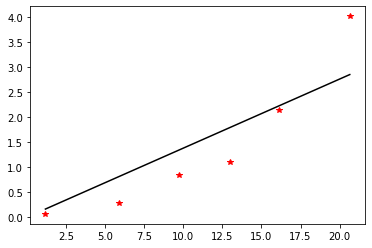

In [ ]:
##Aplicando a Krigagem ordinária
OK = OrdinaryKriging(
    x,
    y,
    z,
    variogram_model="linear",
    verbose=False,
    enable_plotting=True,
    enable_statistics=True,
    coordinates_type='euclidean',
)

In [ ]:
##Criando um grid a partir do valor de Z e Sigma²
Z_pk_krig, sigma_squared_p_krig  = OK.execute("grid", XX_pk_krig, YY_pk_krig)

In [ ]:
##Projeção a ser aplicada no transforme
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "

In [ ]:
##Exportando dado como raster
export_kde_raster(Z = Z_pk_krig, XX = XX_pk_krig, YY = YY_pk_krig,
                  min_x = min_x, max_x = max_x, min_y = min_y, max_y = max_y,
                  proj = proj, filename = "pk_kriging.tif")

In [ ]:
# Open raster
raster_pk = rasterio.open("/content/pk_kriging.tif")

In [ ]:
# Raster de máscara
out_image_pk, out_transform_pk = rio.mask.mask(raster_pk, gdf_amazon.geometry.values, crop = True)

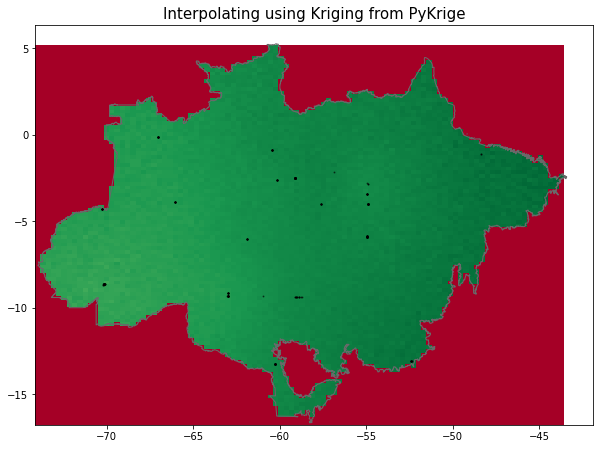

In [ ]:
# Plot data
fig, ax = plt.subplots(1, figsize = (10, 10))
show(out_image_pk, ax = ax, transform = out_transform_pk, cmap = "RdYlGn")
ax.plot(x, y, 'k.', markersize = 2, alpha = 0.5)
gdf_amazon.plot(ax = ax, color = 'none', edgecolor = 'dimgray')
plt.gca().invert_yaxis()

# Set title
ax.set_title('Interpolating using Kriging from PyKrige', fontdict = {'fontsize': '15', 'fontweight' : '3'})

# Display plot
plt.show()

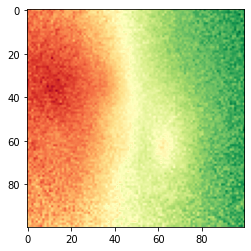

In [ ]:
kt.write_asc_grid(XX_pk_krig, YY_pk_krig, Z_pk_krig, filename="output.asc",no_data=-999.0, style=1)
plt.imshow(Z_pk_krig,cmap = "RdYlGn" )
plt.show()